In [49]:
import cv2 
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [50]:
dataset_path = "../data/fashion_small_1000/"

### Feature Extraction
Extraer los features de las imagenes de la carpeta utilizando opencv con SIFT.

```keypoints, descriptors = sift.detectAndCompute(gray, None)```
- keypoints almacena las coordenadas (x,y) de cada keypoint de la imagen (esquinas, manchas, cambios bruscos de intensidad, etc).
- descriptors almacena los descriptores para cada keypoint de esa imagen (128 descriptores).

In [51]:
# Extracción de descriptores
image_descriptors = [] 
sift = cv2.SIFT_create()

# Iterar sobre cada imagen dentro de la carpeta
for filename in os.listdir(dataset_path): 
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):
        img = cv2.imread(file_path)
        if img is None:
            print(f"No se pudo leer la imagen: {file_path}")
            continue

        # Convertir a grayscale y extraer descriptores
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        
        # TODO: Probar reducir la dimensionalidad de 128 a algo menor para más eficiencia al momento de entrenar todo el dataset

        if descriptors is not None:
            image_descriptors.append(descriptors)
        else:

            print(f"No se encontraron descriptores en: {filename}")

# K-Means para construir el diccionario visual
all_descriptors = np.vstack(image_descriptors) # Para convertir la matriz image_descriptors en un array 2D para el K-Means

# TODO: Para el dataset completo cambiar n_clusters, ver cuales valores producen los mejores resultados
#       quizas guardar objeto kmeans en un vector si tarda mucho en generar
kmeans = KMeans(n_clusters=25, random_state=0, n_init="auto").fit(all_descriptors)

# Construcción de histogramas por imagen
all_histograms = []
for descriptors in image_descriptors:
    histogram = np.zeros(kmeans.n_clusters, dtype=int)

    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    all_histograms.append(histogram)

No se encontraron descriptores en: 37576.jpg
No se encontraron descriptores en: 58610.jpg
No se encontraron descriptores en: 58888.jpg


In [52]:
def create_query_histogram(image_path, kmeans): 
    sift = cv2.SIFT_create()
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    histogram = np.zeros(kmeans.n_clusters, dtype=int)

    if descriptors is not None:
        cluster_assignments = kmeans.predict(descriptors)
        for idx in cluster_assignments:
            histogram[idx] += 1

    # Normalización
    histogram = histogram.astype(float)
    histogram /= np.sum(histogram) if np.sum(histogram) > 0 else 1
    return histogram

Aplicar ponderación TF-IDF

- Los documentos son las imagenes
- Los words son los clusters, cada cluster es un visual word

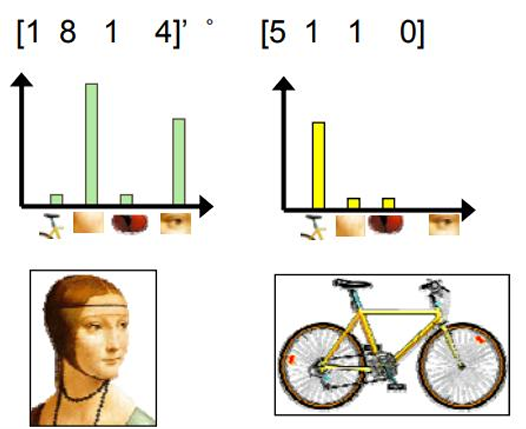

Para la imagen de la bici tengo un histograma, cuento cuantas veces aparece cada descriptor en esa imagen de la bici.

El tf seria algo como [5/7, 1/7, 1/7, 0/7] donde 7 es el total de términos en la imagen (total de palabras en el documento)
- tf = $\frac{n_{id}}{n_d}$
- idf = $log(\frac{N}{n_i})$

El df seria el número de imagenes donde el visual word i aparece (al menos una vez). *la palabra x aparece en y documentos*

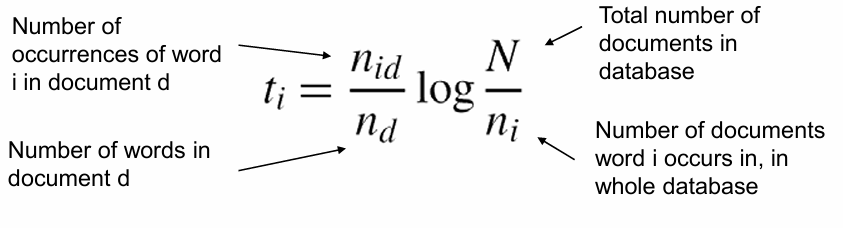

Calcular Document frequency, ejemplo:
```py
histograms = np.array([
  [3, 0, 1],   # Imagen 1
  [0, 2, 0],   # Imagen 2
  [1, 0, 5],   # Imagen 3
])
```
- Visual word 0 aparece en las imagenes 1 y 3. Image 1 and 3.
- Visual word 2 aparece en la imagen 2.
- Visual word 3 aparece en las imagenes 1 y 3.

```histograms > 0``` me da una matriz booleana. Si un visual word aparece en el documento (cluster) seria True:
```py
[
  [True,  False, True ],
  [False, True,  False],
  [True,  False, True ]
]
```
Luego con ```np.sum()```  sumo veo en cuantos documentos aparece cada visual word (cuenta los True).


In [53]:
N = len(image_descriptors) #equivalente a la cantidad de imagenes 
all_histograms = np.array(all_histograms, dtype=np.float32) 

tf = []
#for hist in all_histograms:
#    tf.append(hist / np.sum(hist)) #frecuencia de cada termino (descriptor) en el histograma[i]
tf = all_histograms  


idf = []
for i in range(kmeans.n_clusters): #i es el índice del visual word
    df = np.sum(all_histograms[:, i] > 0) # all_histograms > 0 me da una matriz de booleanos (si aparece el word o no en el doc)
    idf.append(np.log(N / (df + 1e-8))) # Sumo constante chiquita para evitar división por cero


idf_np = np.array(idf, dtype=np.float32)
tf_idf = tf * idf_np
print(tf_idf.shape) # (num_imagenes, num_clusters). tf_idf[i][j] es la importancia del visual word j en la imagen i

(997, 25)


Similitudes coseno


In [54]:
import heapq
image_path = "C:/Users/davie/Downloads/fashion_small/images/5730.jpg" # Path de la query
query_hist = create_query_histogram(image_path, kmeans) # Procesar query
# aplico el tf_idf a la query
query = query_hist * idf_np 

k = 10

heap = []  # heapq es min-heap, popeamos si hay más de k elementos, removiendo el minimo, al final solo quedan los top k más similares
for idx, hist in enumerate(tf_idf):
    dot = np.dot(query, hist)
    norm_query = np.linalg.norm(query)
    norm_hist = np.linalg.norm(hist)

    if norm_query == 0 or norm_hist == 0:
        cosine_sim = 0 # Evitar división por cero
    else:
        cosine_sim = dot / (norm_query * norm_hist)

    heapq.heappush(heap, (cosine_sim, idx))  

    if len(heap) > k:
        heapq.heappop(heap)  # Mantiene solo los k más grandes


top_k = [(sim, idx) for sim, idx in sorted(heap, reverse=True)]
for sim, idx in top_k:
    print(f"Imagen {idx}: similitud: {sim:.4f}")


Imagen 316: similitud: 0.8347
Imagen 680: similitud: 0.7823
Imagen 488: similitud: 0.7487
Imagen 863: similitud: 0.7484
Imagen 53: similitud: 0.7263
Imagen 107: similitud: 0.7217
Imagen 438: similitud: 0.7116
Imagen 179: similitud: 0.7108
Imagen 588: similitud: 0.7053
Imagen 416: similitud: 0.6994


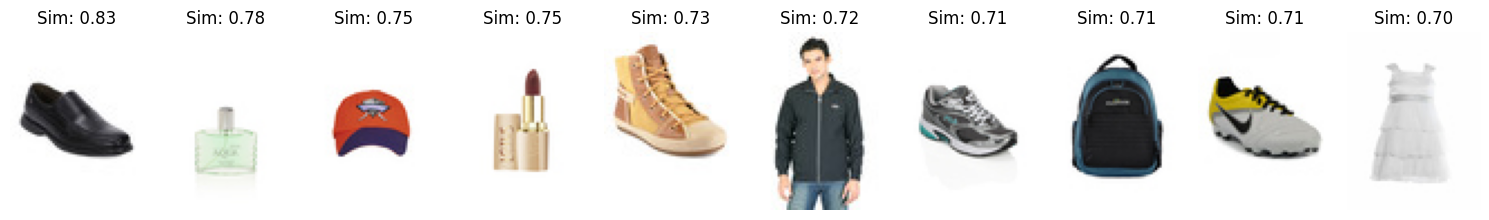

In [55]:
image_filenames = sorted([
    filename for filename in os.listdir(dataset_path)
    if filename.lower().endswith(('.jpg', '.jpeg', '.png'))
])
import cv2
import matplotlib.pyplot as plt

def show_top_similar_images(top_k, image_filenames, dataset_path):
    plt.figure(figsize=(15, 5))
    for rank, (sim, idx) in enumerate(top_k):
        img_path = os.path.join(dataset_path, image_filenames[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        plt.subplot(1, len(top_k), rank + 1)
        plt.imshow(img)
        plt.title(f"Sim: {sim:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_top_similar_images(top_k, image_filenames, dataset_path)